<a href="https://colab.research.google.com/github/Tzoll87/Codes/blob/master/A_B_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
data = pd.DataFrame(pd.read_csv('ABtest.csv'))

Exploring the dataset

In [ ]:
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [ ]:
data.experiment.value_counts(dropna = False)

control    4071
exposed    4006
Name: experiment, dtype: int64

In [ ]:
#Adding up all answers to see amount of total interactions with button
data['Answer'] = data['yes']+data['no']

In [ ]:
grouped = data.groupby('experiment').sum()[['Answer']]

In [ ]:
grouped.head()

,Answer
experiment,
control,586
exposed,657


In [ ]:
value = (grouped.loc['exposed'] - grouped.loc['control']) / grouped.loc['control'] * 100

In [ ]:
#Does the exposed group reach a higher level of interaction, and if they do, by how much?
value

Answer    12.116041
dtype: float64

In [ ]:
print("Data shows that the customers being exposed to the test are ", round(value[0],2), '% more willing to click on and of the answers.')

Data shows that the customers being exposed to the test are  12.12 % more willing to click on and of the answers


In [ ]:
# Creating an list with bootstrapped means for each both groups to see by random sampling how does the difference between groups occurs
bootstrap = []
iterations = 10000
for i in range(iterations):
    boot_mean = data.sample(frac = 1, replace = True).groupby('experiment').sum()['Answer']
    bootstrap.append(boot_mean)
  
bootstrap = pd.DataFrame(bootstrap)
bootstrap.head()



In [ ]:
bootstrap.head()

experiment,control,exposed
Answer,581,669
Answer,587,657
Answer,575,692
Answer,611,641
Answer,589,642


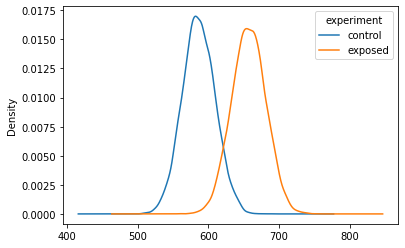

In [ ]:
#Adding kde plot to show the density of the number of interactions by AB group on sample dataset
bootstrap.plot.kde()
plt.show()

In [ ]:
bootstrap['diff'] = bootstrap['exposed'] - bootstrap['control']

Text(0.5, 0, 'Difference of mean by version')

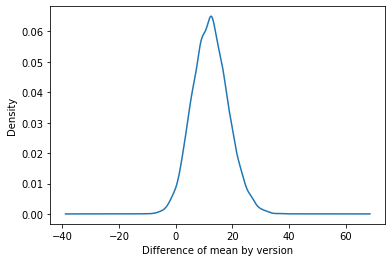

In [ ]:
# Adding a column with the % difference between the two AB-groups, and showing how common it is
bootstrap['diff_perc'] = bootstrap['diff'] / bootstrap['control'] * 100

# Ploting the bootstrap % difference
ax = bootstrap['diff_perc'].plot.kde()
ax.set_xlabel("Difference of mean by version")

In [ ]:
prob = (bootstrap['diff_perc'] > 10).sum() / bootstrap.shape[0]
print(prob*100, '%')

63.24999999999999 %


Looking at the significance of the difference

In [ ]:
conversion_exp = grouped.loc['exposed'] / data.experiment.value_counts()[1]
conversion_control = grouped.loc['control'] / data.experiment.value_counts()[0]

In [ ]:
exp_size = data.experiment.value_counts()[1]
control_size = data.experiment.value_counts()[0]

In [ ]:
def get_pvalue(con_conv, test_conv, con_size, test_size):  
    lift =  - abs(test_conv - con_conv)

    scale_one = con_conv * (1 - con_conv) * (1 / con_size)
    scale_two = test_conv * (1 - test_conv) * (1 / test_size)
    scale_val = (scale_one + scale_two)**0.5

    p_value = 2 * stats.norm.cdf(lift, loc = 0, scale = scale_val )

    return p_value

In [ ]:
p_value = get_pvalue(conversion_exp, conversion_control, exp_size, control_size)

In [ ]:
if p_value >= 0.05:
    print("Not Significant")
else:
    print("Significant Result")

Significant Result
